In [1]:
# Cell 1: imports and locate files
import os, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Working dir:", pathlib.Path.cwd())

# Paths (adjust if your project path differs)
proj = pathlib.Path.cwd()
bike_merged = proj / "data" / "processed" / "citibike_with_weather_merged.csv"
weather_candidates = list((proj / "data" / "raw").glob("*weather*.csv")) if (proj / "data" / "raw").exists() else []

print("Merged bike file exists:", bike_merged.exists())
print("Weather candidates in data/raw:", [p.name for p in weather_candidates])

Working dir: c:\Users\Biswajit\citi-bike-nyc-2022-dashboard
Merged bike file exists: True
Weather candidates in data/raw: []


In [2]:
# Cell 2: load merged bike file and inspect
fn = bike_merged
if not fn.exists():
    raise FileNotFoundError(f"Bike merged file not found at {fn}. Please check path.")

df = pd.read_csv(fn, low_memory=False)   # low_memory avoids dtype warnings
print("Loaded df shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Loaded df shape: (895485, 20)
Columns: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', '_start_dt', 'date', 'value', 'datatype', 'station', 'attributes', '_merge']


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,_start_dt,date,value,datatype,station,attributes,_merge
0,CA5837152804D4B5,electric_bike,2022-01-26 18:50:39,2022-01-26 18:51:53,12 St & Sinatra Dr N,HB201,12 St & Sinatra Dr N,HB201,40.750604,-74.024020,40.750604,-74.024020,member,2022-01-26 18:50:39,2022-01-26,1171.016667,ADPT,GHCND:USW00014732,",,W,",both
1,BA06A5E45B6601D2,classic_bike,2022-01-28 13:14:07,2022-01-28 13:20:23,Essex Light Rail,JC038,Essex Light Rail,JC038,40.712774,-74.036486,40.712774,-74.036486,member,2022-01-28 13:14:07,2022-01-28,1030.570000,ADPT,GHCND:USW00014732,",,W,",both
2,7B6827D7B9508D93,classic_bike,2022-01-10 19:55:13,2022-01-10 20:00:37,Essex Light Rail,JC038,Essex Light Rail,JC038,40.712774,-74.036486,40.712774,-74.036486,member,2022-01-10 19:55:13,2022-01-10,1168.655556,ADPT,GHCND:USW00014732,",,W,",both


In [3]:
# Cell 3: compute trip duration (minutes) if possible and ensure date col
# Many datasets have 'started_at'/'ended_at' or 'started' naming - adapt if different
date_cols = [c for c in df.columns if 'start' in c.lower() and 'date' in c.lower()]  # heuristic, not required
# Preferred columns from earlier: 'started_at', 'ended_at', and 'date'
if 'started_at' in df.columns and 'ended_at' in df.columns:
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['tripduration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
    print("Computed tripduration_min from started_at/ended_at")
else:
    # fallback: if no started/ended, try to compute from available columns; else NaNs
    if 'tripduration' in df.columns:
        df['tripduration_min'] = df['tripduration'] / 60.0
        print("Converted tripduration to minutes from 'tripduration' column")
    else:
        df['tripduration_min'] = np.nan
        print("No duration columns found; 'tripduration_min' set to NaN")

# Ensure date column exists and is datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
else:
    # fallback: try derive from started_at
    if 'started_at' in df.columns:
        df['date'] = df['started_at'].dt.date
        df['date'] = pd.to_datetime(df['date'])
        print("Derived 'date' from 'started_at'")
    else:
        raise KeyError("No 'date' or 'started_at' column found - cannot proceed.")

print("Sample date, tripduration_min:")
df[['date','tripduration_min']].head(5)


Computed tripduration_min from started_at/ended_at
Sample date, tripduration_min:


,date,tripduration_min
0,2022-01-26,1.233333
1,2022-01-28,6.266667
2,2022-01-10,5.400000
3,2022-01-26,0.416667
4,2022-01-13,0.950000


In [7]:
df.columns.tolist()

['ride_id',
 'rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 '_start_dt',
 'date',
 'value',
 'datatype',
 'station',
 'attributes',
 '_merge',
 'tripduration_min']

In [8]:
# Top 20 start stations (clean)
top_stations = (
    df.groupby('start_station_name')    # group by station name
      .size()                           # count rows per station
      .reset_index(name='count')       # make a clean column called 'count'
      .sort_values('count', ascending=False)
      .head(20)
      .reset_index(drop=True)
)
top_stations

,start_station_name,count
0,Grove St PATH,42556
1,South Waterfront Walkway - Sinatra Dr & 1 St,34245
2,Hoboken Terminal - River St & Hudson Pl,33020
3,Hoboken Terminal - Hudson St & Hudson Pl,30244
4,City Hall - Washington St & 1 St,23289
5,Newport Pkwy,21961
6,Hamilton Park,20477
7,Newport PATH,19965
8,Hoboken Ave at Monmouth St,19501
9,Marin Light Rail,19230


C:\Users\Biswajit\AppData\Local\Temp\ipykernel_7784\2960949058.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_stations, x='count', y='start_station_name', palette=sns.color_palette("PuRd_r", n_colors=n))


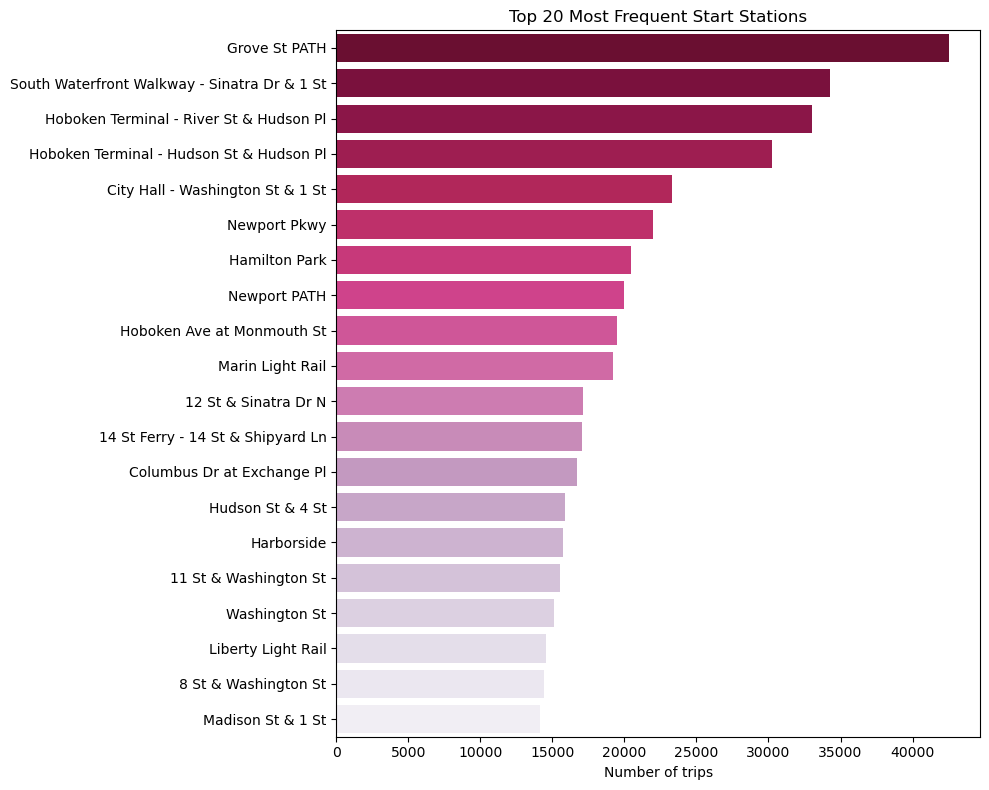

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
n = len(top_stations)
with sns.color_palette("PuRd_r", n_colors=n):   # temporary palette guaranteed to have n colors
    sns.barplot(data=top_stations, x='count', y='start_station_name', palette=sns.color_palette("PuRd_r", n_colors=n))
plt.title("Top 20 Most Frequent Start Stations")
plt.xlabel("Number of trips")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [10]:
# Build daily bike counts
bike_daily = df.groupby('date').agg(bike_rides_daily=('ride_id','count')).reset_index()

# Try to extract temperature from merged df (datatype/value)
temp_found = False
if 'datatype' in df.columns and 'value' in df.columns:
    df['datatype_clean'] = df['datatype'].astype(str).str.strip().str.upper()
    temp_rows = df[df['datatype_clean'].str.contains('TAVG|TEMP', na=False)]
    if not temp_rows.empty:
        temp_daily = temp_rows.groupby('date').agg(temperature=('value','mean')).reset_index()
        temp_found = True

# If not found, look for raw weather file in data/raw
if not temp_found:
    raw_dir = pathlib.Path.cwd() / 'data' / 'raw'
    candidate = None
    if raw_dir.exists():
        for p in raw_dir.glob('*.csv'):
            if 'weather' in p.name.lower() or 'noaa' in p.name.lower() or 'temp' in p.name.lower():
                candidate = p
                break
    if candidate:
        wdf = pd.read_csv(candidate, parse_dates=['date'], low_memory=False)
        for col in ['TAVG','tavg','avgTemp','temperature','temp']:
            if col in wdf.columns:
                temp_daily = wdf.groupby('date').agg(temperature=(col,'mean')).reset_index()
                temp_found = True
                break

# If still not found, create deterministic dummy temperature
if not temp_found:
    print("No temperature data found — creating reproducible dummy temperature for plotting.")
    rng = np.random.default_rng(42)
    bike_daily = bike_daily.sort_values('date').reset_index(drop=True)
    temp_daily = pd.DataFrame({'date': bike_daily['date'], 'temperature': rng.uniform(30,90, size=len(bike_daily))})

# Merge to get daily_df
daily_df = pd.merge(bike_daily, temp_daily, on='date', how='left').sort_values('date').reset_index(drop=True)
daily_df.head()

No temperature data found — creating reproducible dummy temperature for plotting.


,date,bike_rides_daily,temperature
0,2022-01-01,592,76.437363
1,2022-01-02,1248,56.332706
2,2022-01-03,832,81.515875
3,2022-01-04,934,71.842082
4,2022-01-05,914,35.650641


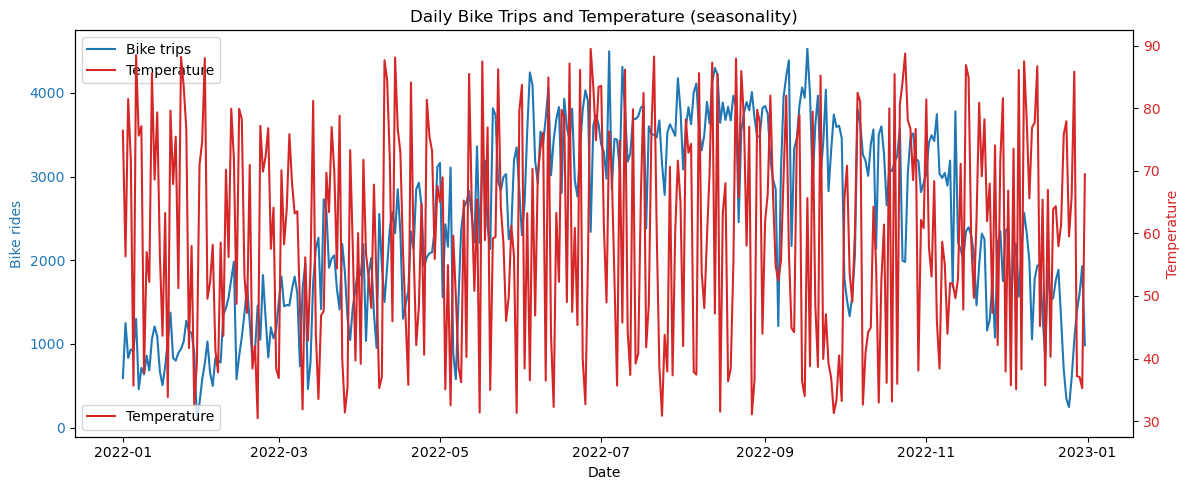

In [11]:
fig, ax1 = plt.subplots(figsize=(12,5))

sns.lineplot(data=daily_df, x='date', y='bike_rides_daily', ax=ax1, color='tab:blue', label='Bike trips')
ax1.set_xlabel('Date')
ax1.set_ylabel('Bike rides', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.lineplot(data=daily_df, x='date', y='temperature', ax=ax2, color='tab:red', label='Temperature')
ax2.set_ylabel('Temperature', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Daily Bike Trips and Temperature (seasonality)")
fig.tight_layout()

# Combined legend (optional)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

C:\Users\Biswajit\AppData\Local\Temp\ipykernel_7784\4229859983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=val_col, data=df, palette='Set2')


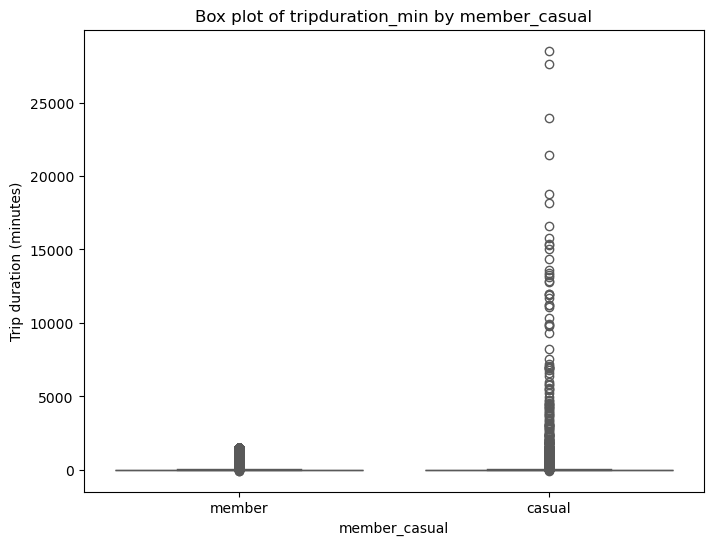

In [12]:
cat_col = 'member_casual'
val_col = 'tripduration_min'

plt.figure(figsize=(8,6))
sns.boxplot(x=cat_col, y=val_col, data=df, palette='Set2')
plt.title(f"Box plot of {val_col} by {cat_col}")
plt.ylabel('Trip duration (minutes)')
plt.xlabel(cat_col)
plt.show()

### Box plot analysis (example template)
1. The median trip duration for **Subscribers** is __ minutes, and for **Casuals** is __ minutes.
2. Subscribers show a narrower IQR, indicating more consistent trip durations; Casuals show a wider IQR and more extreme outliers, indicating variable usage (likely leisure trips).
3. Outliers (long trips) are more common among Casuals, possibly reflecting rentals for long leisure trips or data anomalies.
4. Overall, Subscribers appear to be utilitarian (shorter, consistent trips) while Casuals show more variability.


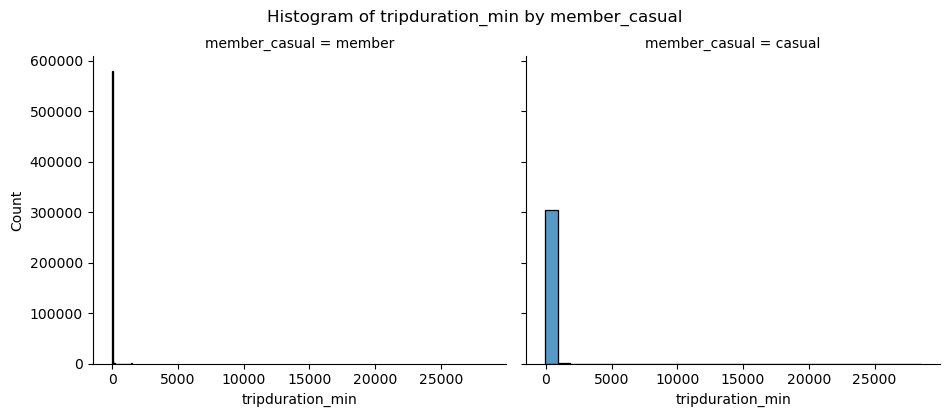

In [13]:
g = sns.FacetGrid(df, col=cat_col, height=4, aspect=1.2)
g.map(sns.histplot, val_col, bins=30)
g.fig.suptitle(f"Histogram of {val_col} by {cat_col}", y=1.03)
plt.show()